<h1>Прогнозирование объемов потребления электроэнергии<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Используемые-ресурсы" data-toc-modified-id="Используемые-ресурсы-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Используемые ресурсы</a></span></li><li><span><a href="#Формирование-базы-данных" data-toc-modified-id="Формирование-базы-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Формирование базы данных</a></span></li><li><span><a href="#Подготовка-обучающего-и-тестового-фрейма" data-toc-modified-id="Подготовка-обучающего-и-тестового-фрейма-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка обучающего и тестового фрейма</a></span></li><li><span><a href="#Анализ-структуры-исходных-данных" data-toc-modified-id="Анализ-структуры-исходных-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ структуры исходных данных</a></span></li><li><span><a href="#Корреляция-числовых-и-категориальных-признаков" data-toc-modified-id="Корреляция-числовых-и-категориальных-признаков-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Корреляция числовых и категориальных признаков</a></span></li><li><span><a href="#Регрессия-Бустингом" data-toc-modified-id="Регрессия-Бустингом-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Регрессия Бустингом</a></span><ul class="toc-item"><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>XGBoost</a></span><ul class="toc-item"><li><span><a href="#Оценка-ценности-признаков" data-toc-modified-id="Оценка-ценности-признаков-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Оценка ценности признаков</a></span></li><li><span><a href="#Обучение-на-потерях-валидационных-данных-при-кросс-валидации-генеральной-совокупности" data-toc-modified-id="Обучение-на-потерях-валидационных-данных-при-кросс-валидации-генеральной-совокупности-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>Обучение на потерях валидационных данных при кросс-валидации генеральной совокупности</a></span></li><li><span><a href="#Обучение-на-потерях-валидационных-данных-при-кросс-валидации-генеральной-совокупности-(с-фильтрацией-исходных-признаков-и-временного-диапазона)" data-toc-modified-id="Обучение-на-потерях-валидационных-данных-при-кросс-валидации-генеральной-совокупности-(с-фильтрацией-исходных-признаков-и-временного-диапазона)-6.1.3"><span class="toc-item-num">6.1.3&nbsp;&nbsp;</span>Обучение на потерях валидационных данных при кросс-валидации генеральной совокупности (с фильтрацией исходных признаков и временного диапазона)</a></span></li></ul></li></ul></li></ul></div>

**Исследуемый субъект:** республика Татарстан. Генеральная совокупность: 01.04.2013 – 29.09.2023, тестовая выборка: 2023 год (09.01.2023 – 29.09.2023)

# Используемые ресурсы

In [4]:
import os
import shutil
import requests
import datetime
import warnings
import pandas as pd
from bs4 import BeautifulSoup

import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xgboost as xgb
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# Формирование базы данных

In [2]:
headers = {
    'Accept': '*/*',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36'
}

t = {'ё': 'yo', 'а': 'a', 'б': 'b', 'в': 'v', 'г': 'g', 'д': 'd', 'е': 'e', 'ж': 'zh',
     'з': 'z', 'и': 'i', 'й': 'y', 'к': 'k', 'л': 'l', 'м': 'm', 'н': 'n', 'о': 'o', 'п': 'p',
     'р': 'r', 'с': 's', 'т': 't', 'у': 'u', 'ф': 'f', 'х': 'h', 'ц': 'c', 'ч': 'ch', 'ш': 'sh',
     'щ': 'shch', 'ъ': '', 'ы': 'y', 'ь': '', 'э': 'e', 'ю': 'yu', 'я': 'ya'}
def translate(text: str, sep = '_'):
    tx = ''
    for i in text:
        if i != ' ':
            tx += t.get(i, i)
        else:
            tx += sep
    return tx

valid_data = {}
with open('index.html', 'r', encoding='utf-8') as file:
    src = file.read() 

soup = BeautifulSoup(src, 'html.parser')
anch = soup.find_all('a')

for item in anch:
    valid_data[item.text] = item.get('href')[item.get('href').find('_', 36)+1:item.get('href').rfind('_')-5]
def get_data():
    key = input('\n'.join(valid_data.keys()) + '\n')
    tr_key = translate(key.lower())
    if not os.path.exists(f'./{tr_key.capitalize()}'):
        os.mkdir(f'./{tr_key.capitalize()}')
    for i in range(2013, 2024):
        for j in range(1, 13):
            req = requests.get(
                url = f'https://www.atsenergo.ru/dload/fact_region/{i}{j:02}01/{i}{j:02}01_{valid_data[key]}_fact_region.xls',
                headers=headers,
                verify=False
                )
            if req.status_code == 404:
                continue
            try:
                if not os.path.exists(f'./{tr_key.capitalize()}/{tr_key}_{i}_{j:02}__{valid_data[key]}.xls'):
                    with open(f'./{tr_key.capitalize()}/{tr_key}_{i}_{j:02}__{valid_data[key]}.xls', 'wb') as file:
                        file.write(req.content)
            except Exception as ex:
                print(ex)
    return transformation_data(tr_key)

def transformation_data(key):
    for adress, dirs, files in os.walk(f'./{key.capitalize()}'):
        for name in files:
            url = os.path.join(adress, name)
            df= pd.read_excel(url, index_col=False)
            if pd.isna(df.iloc[-1, 1]):
                df = df.iloc[6:-3]
            else:
                df = df.iloc[6:]
            df.columns = ['Date', 'Hour', 'Volume']
            df = df.reset_index(drop=True)
            df['Date'] = df['Date'].apply(lambda x: x.replace('.', '-'))
            df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
            for i, j in enumerate(['Year', 'Month', 'Day']):
                if j == 'Year':
                    df.insert(i, j, df['Date'].dt.year)
                elif j == 'Month':
                    df.insert(i, j, df['Date'].dt.month)
                else:
                    df.insert(i, j, df['Date'].dt.day)
            df = df.drop(columns='Date')
            df.to_excel(url+'x', index=False)
            os.remove(url)
    return result_dataframe(key)
            
def result_dataframe(key):
    files_url = []
    result = pd.DataFrame()
    for adress, dirs, files in os.walk(f'./{key.capitalize()}'):
        for name in files:
            files_url.append(os.path.join(adress, name))
    for file in files_url:
        df = pd.read_excel(file, index_col=False)
        result = result._append(df)
    shutil.rmtree(f'./{key.capitalize()}')
    return result

In [ ]:
warnings.filterwarnings('ignore') # супрессим предупреждения https

df = get_data()

warnings.filterwarnings("default") # возвращаем предупреждения к дефолтным настройкам

# Подготовка обучающего и тестового фрейма

In [3]:
# формируем генеральную совокупность
df = df[['Year', 'Month', 'Day', 'Hour', 'Volume']]

df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df['Weekday'] = df['date'].dt.weekday  # добавление дня недели
df = df.drop('date', axis=1)
df = df.drop_duplicates(subset=['Year', 'Month', 'Day', 'Hour'])  # удаление возможных дубликатов
df = df[['Year', 'Month', 'Day', 'Hour', 'Weekday', 'Volume']]  # упорядочиваем столбцы
df.reset_index(drop=True, inplace=True)

# формируем обучающий датафрейм
df_train = df[df['Year'] < 2023]

# формируем тестовую выборку
df_test = df[df['Year'] == 2023]
df_test.reset_index(drop=True, inplace=True)



Алтайский край
Астраханская область
Белгородская область
Брянская область
Владимирская область
Волгоградская область
Вологодская область
Воронежская область
Город Севастополь
Забайкальский край
Ивановская область
Иркутская область
Кабардино-Балкарская Республика
Калужская область
Карачаево-Черкесская Республика
Кемеровская область
Кировская область
Костромская область
Краснодарский край
Красноярский край
Курганская область
Курская область
Ленинградская область
Липецкая область
Московская область
Мурманская область
Нижегородская область
Новгородская область
Новосибирская область
Омская область
Оренбургская область
Орловская область
Пензенская область
Пермский край
Псковская область
Республика Алтай
Республика Башкортостан
Республика Бурятия
Республика Дагестан
Республика Ингушетия
Республика Калмыкия
Республика Карелия
Республика Крым
Республика Марий Эл
Республика Мордовия
Республика Северная Осетия-Алания
Республика Татарстан
Республика Тыва
Республика Хакасия
Ростовская область
Рязан

In [5]:
#f.to_excel('Tatarstan.xlsx')
df

,Year,Month,Day,Hour,Weekday,Volume
0,2013,4,1,1,0,2814.717
1,2013,4,1,2,0,2747.458
2,2013,4,1,3,0,2734.133
3,2013,4,1,4,0,2736.587
4,2013,4,1,5,0,2796.396
...,...,...,...,...,...,...
63448,2023,12,29,19,4,3735.211
63449,2023,12,29,20,4,3675.452
63450,2023,12,29,21,4,3653.876
63451,2023,12,29,22,4,3598.927


In [9]:
df.info() # пропуски в данных отсутствуют

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63453 entries, 0 to 63452
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     63453 non-null  int64  
 1   Month    63453 non-null  int64  
 2   Day      63453 non-null  int64  
 3   Hour     63453 non-null  int64  
 4   Weekday  63453 non-null  int64  
 5   Volume   63453 non-null  float64
dtypes: float64(1), int64(5)
memory usage: 2.9 MB


In [10]:
df_train

,Year,Month,Day,Hour,Weekday,Volume
0,2013,4,1,1,0,2814.717
1,2013,4,1,2,0,2747.458
2,2013,4,1,3,0,2734.133
3,2013,4,1,4,0,2736.587
4,2013,4,1,5,0,2796.396
...,...,...,...,...,...,...
57523,2022,12,30,20,4,3664.178
57524,2022,12,30,21,4,3609.495
57525,2022,12,30,22,4,3569.476
57526,2022,12,30,23,4,3429.831


In [11]:
df_test

,Year,Month,Day,Hour,Weekday,Volume
0,2023,1,9,1,0,3439.149
1,2023,1,9,2,0,3381.470
2,2023,1,9,3,0,3349.565
3,2023,1,9,4,0,3362.296
4,2023,1,9,5,0,3385.085
...,...,...,...,...,...,...
5920,2023,12,29,19,4,3735.211
5921,2023,12,29,20,4,3675.452
5922,2023,12,29,21,4,3653.876
5923,2023,12,29,22,4,3598.927


# Анализ структуры исходных данных

*График структуры потребления электрической энергии за 10 лет*

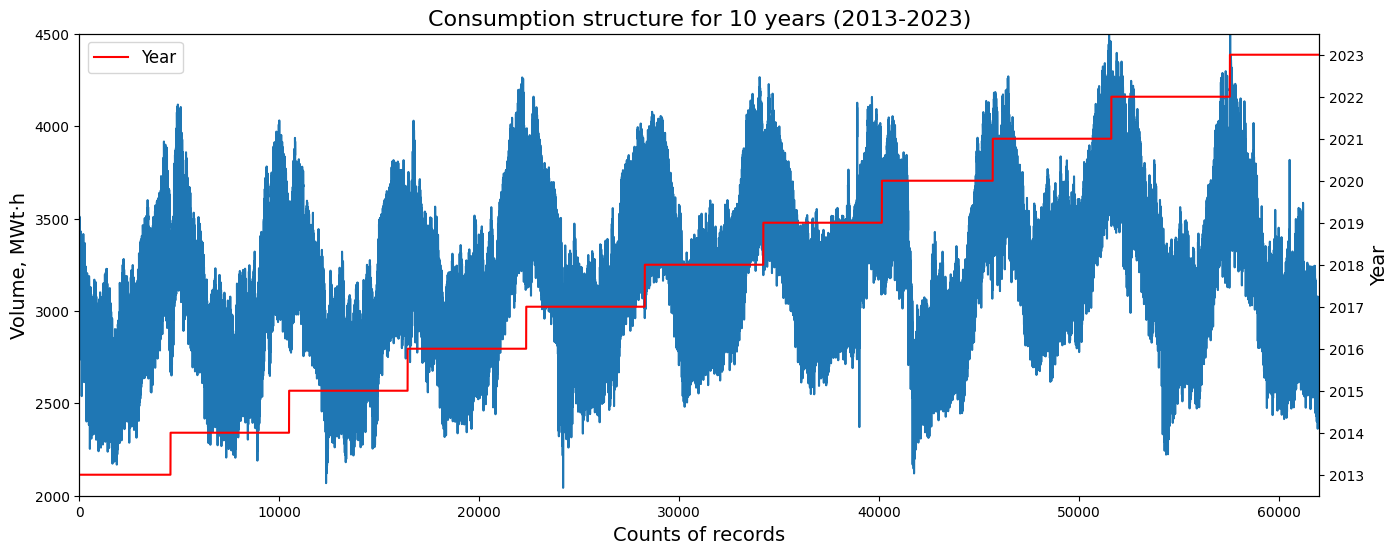

In [19]:
'''df[['Volume']].plot(figsize=(16,6), 
                    title='Сonsumption structure for 10 years (2013-2023)',
                    xlim=(0, 62000), ylim=(2000, 4500),
                    xlabel='Counts of records',
                    ylabel='Volume, kWt·h', 
                    legend=None,
                    grid=True)'''

fig, df_volume = plt.subplots(figsize=(16,6))
df_year = df_volume.twinx()

df_volume.plot(df['Volume'], label='Volume')
df_year.plot(df['Year'], label='Year', color='r')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(0, 62000)  #  поправить параметры при изменении периода исследования
df_volume.set_ylim(2000, 4500)  #  поправить параметры при смене региона
df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
df_volume.set_xlabel('Counts of records', fontsize = 14)
df_year.set_ylabel('Year', fontsize = 14)
df_year.yaxis.set_major_locator(ticker.MultipleLocator(1.00))

plt.title('Сonsumption structure for 10 years (2013-2023)', fontsize = 16)
plt.legend()

*График структуры потребления электрической энергии по месяцам 2022 года*

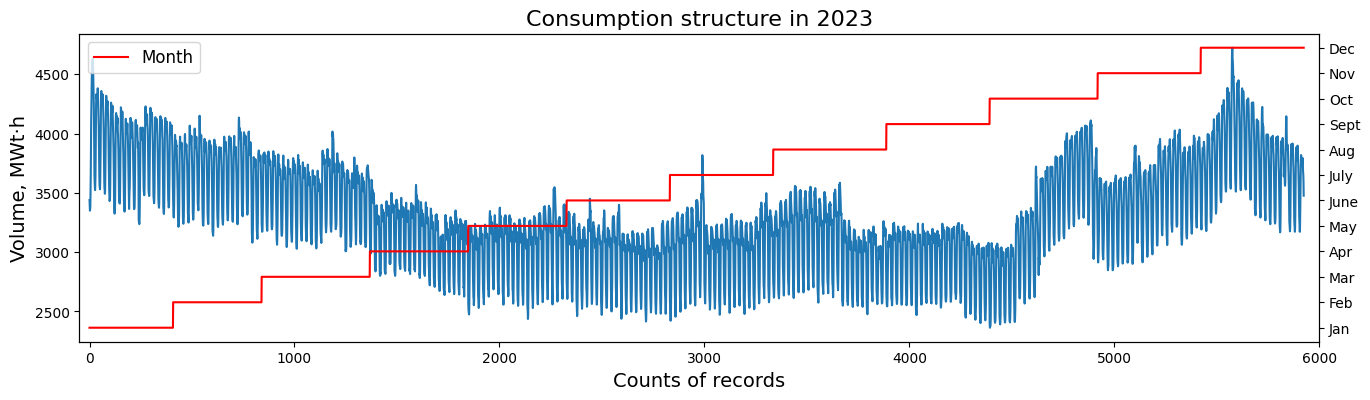

In [12]:
df_last_year = df[df['Year'] == 2023]
df_last_year.reset_index(drop=True, inplace=True)

fig, df_volume = plt.subplots(figsize=(16,4))
df_month = df_volume.twinx()

df_volume.plot(df_last_year['Volume'], label='Volume')
df_month.plot(df_last_year['Month'], label='Month', color='r')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(-50, 6000)
df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
df_volume.set_xlabel('Counts of records', fontsize = 14)
df_month.yaxis.set_major_locator(ticker.FixedLocator([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]))
df_month.yaxis.set_major_formatter(ticker.FixedFormatter(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']))

plt.title('Сonsumption structure in 2023', fontsize = 16)
plt.legend()

*График структуры потребления электрической энергии по дням недели в сентябре 2023 года*

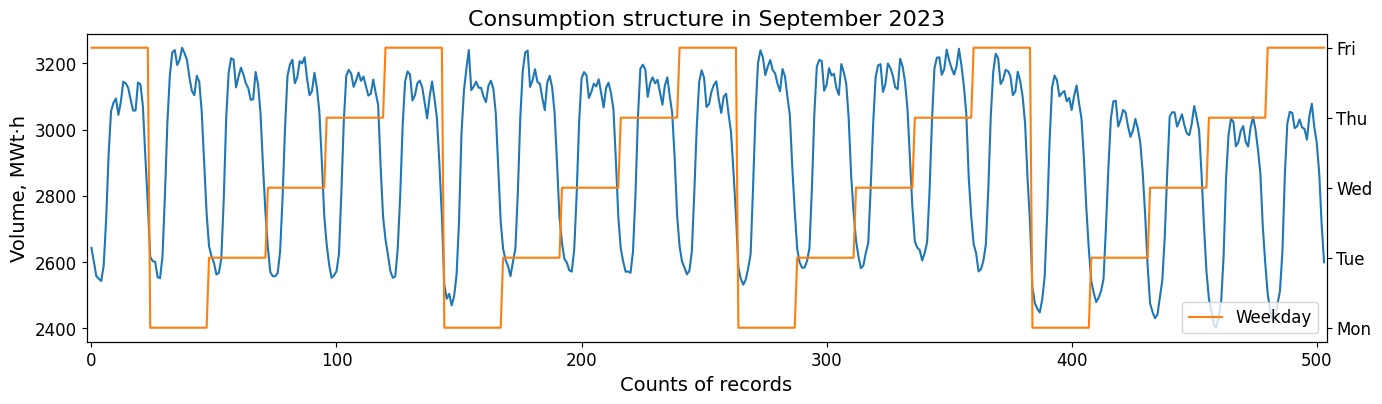

In [22]:
df_sept = df_test[df_test['Month'] == 9]
df_sept.reset_index(drop=True, inplace=True)

fig, df_volume = plt.subplots(figsize=(16,4))
df_weekday = df_volume.twinx()

df_volume.plot(df_sept['Volume'], label='Volume')
df_weekday.plot(df_sept['Weekday'], label='Weekday', color='#ff7f0e')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(-2, 504)
df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
df_volume.set_xlabel('Counts of records', fontsize = 14)
df_weekday.yaxis.set_major_locator(ticker.FixedLocator([0, 1, 2, 3, 4, 5, 6]))
df_weekday.yaxis.set_major_formatter(ticker.FixedFormatter(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))

plt.title('Сonsumption structure in September 2023', fontsize = 16)
plt.legend()

# Корреляция числовых и категориальных признаков

In [13]:
# корреляция исходных значений и целевого признака
color_map = sns.color_palette("vlag", as_cmap=True)

df.corr('pearson').style.background_gradient(cmap=color_map, vmin = -1, vmax=1)

,Year,Month,Day,Hour,Weekday,Volume
Year,1.000000,-0.046257,-0.000433,-0.000124,0.009688,0.285233
Month,-0.046257,1.000000,-0.040279,-0.000098,-0.005180,-0.028807
Day,-0.000433,-0.040279,1.000000,-0.000125,-0.003965,0.016131
Hour,-0.000124,-0.000098,-0.000125,1.000000,-0.000036,0.341946
Weekday,0.009688,-0.005180,-0.003965,-0.000036,1.000000,0.007590
Volume,0.285233,-0.028807,0.016131,0.341946,0.007590,1.000000


**Вывод**: ощутимая корреляционная связь объема с годом и часом

# Регрессия Бустингом

## XGBoost

### Оценка ценности признаков

In [18]:
# классификация ценности признаков в контексте регрессора XGBoost
selector = xgb.XGBRegressor(random_state=10)
result = selector.fit(df[['Year', 'Month', 'Day', 'Hour', 'Weekday']], df['Volume'])
features_table = pd.DataFrame(result.feature_importances_, index = dataset[0], columns = ['importance'])

# исследуемый список датасетов с учетом ценности признаков
dataset = list([['Year', 'Month', 'Day', 'Hour', 'Weekday'],
                ['Year', 'Month', 'Day', 'Hour'],
                ['Year', 'Month', 'Hour']])

predictions = list(['Predicted',
                    'Predicted_W',
                    'Predicted_WD'])

messages = list(['Full set:              ',
                 'Without Weekday:       ',
                 'Without Weekday & Day:'])

features_table.sort_values(by='importance', ascending=False)

,importance
Hour,0.532517
Month,0.327836
Year,0.108418
Day,0.023734
Weekday,0.007495


### Обучение на потерях валидационных данных при кросс-валидации генеральной совокупности
Обучение выполняется по методике, описанной в [статье](https://www.mdpi.com/2411-5134/8/5/114): валидация 1 к 3, количество деревьев `n_estimators` – 100, генеральная совокупность данных – за 3 года

In [28]:
%%time

# поиск лучших гиперпараметров XGBoost с помощью сетки гиперпараметров
df_boost_train = df[df['Year'] > 2020]  # формируем обучающий датафрейм
df_boost_test = df_test.copy()

XGB_search = GridSearchCV(estimator=xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators = 100), 
                          param_grid={'max_depth': range(2, 20)}, 
                          scoring='neg_mean_absolute_percentage_error', 
                          verbose = 0,
                          cv=3)

XGB_search.fit(df_boost_train[['Year', 'Month', 'Day', 'Hour', 'Weekday']], df_boost_train['Volume'])

XGB_best = XGB_search.best_estimator_

XGB_best.fit(df_boost_train[['Year', 'Month', 'Day', 'Hour', 'Weekday']], df_boost_train['Volume'])

CPU times: total: 3min 5s
Wall time: 1min 59s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [29]:
# Предсказываем пиковый час
df_boost_test['Predicted'] = XGB_best.predict(df_boost_test[['Year', 'Month', 'Day', 'Hour', 'Weekday']].values.reshape(-1, 5))

# Метрики качества прогноза
print('MAE:', f"{MAE(df_boost_test['Predicted'], df_boost_test['Volume']):.2f} [MW]",
      '\nMAPE:', f"{MAPE(df_boost_test['Predicted'], df_boost_test['Volume']):.2%}")

hyper_params = XGB_best.get_params()
print(f"max_depth: {hyper_params['max_depth']}, n_estimators: {hyper_params['n_estimators']}")

MAE: 93.77 [MW] 
MAPE: 2.83%
max_depth: 2, n_estimators: 100


**Вывод**: результат ожидаемо высокий, однако валидность подхода стоит под вопросом. Необходимо испытывать на реальном кейсе

### Обучение на потерях валидационных данных при кросс-валидации генеральной совокупности (с фильтрацией исходных признаков и временного диапазона)

In [30]:
%%time

# инициализируем итоговый датафрейм по всем временным интервалам (3-10 лет)
df_general_result = pd.DataFrame({'period':[],  # рассматриваемый временной интервал
                                  'set': [],  # тип датасета
                                  'MAE [MW]':[],  # минимальная средняя абсолютная ошибка
                                  'MAPE':[],  # минимальная средняя относительная ошибка
                                  'max_depth':[],  # оптимальная глубина дерева
                                  'n_estimators':[]})  # оптимальное количество деревьев

index = 0  # индекс узла сетки итогового датафрейма

df_boost_test = df_test.copy()

for time in range(2021, 2012, -1):

    df_boost_train = df[df['Year'] >= time]  # формируем обучающий датафрейм под рассматриваемый интервал

    for data in range(len(dataset)):  # выбор датасета

        XGB_search = GridSearchCV(estimator=xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators = 100), 
                          param_grid={'max_depth': range(2, 11)}, 
                          scoring='neg_mean_absolute_percentage_error', 
                          verbose = 0,
                          cv=3)

        XGB_search.fit(df_boost_train[dataset[data]], df_boost_train['Volume'].values)

        XGB_best = XGB_search.best_estimator_

        XGB_best.fit(df_boost_train[dataset[data]], df_boost_train['Volume'].values)
        
        df_boost_test[predictions[data]] = XGB_best.predict(df_boost_test[dataset[data]])
        
        hyper_params = XGB_best.get_params()

        # заполняем итоговый датафрейм лучшим результатом для данной выборки
        df_general_result.loc[index] = (2024 - time, messages[data], 
                                        MAE(df_boost_test[predictions[data]], df_boost_test['Volume']), 
                                        MAPE(df_boost_test[predictions[data]], df_boost_test['Volume']),
                                        hyper_params['max_depth'],
                                        hyper_params['n_estimators'])
        index += 1;

#print()

CPU times: total: 17min 22s
Wall time: 5min 10s


In [31]:
df_general_result.style.highlight_min(color='yellowgreen', subset='MAPE')

,period,set,MAE [MW],MAPE,max_depth,n_estimators
0,3,Full set:,93.769364,0.028265,2,100
1,3,Without Weekday:,95.173794,0.028767,2,100
2,3,Without Weekday & Day:,112.287323,0.033920,2,100
3,4,Full set:,100.291773,0.030331,2,100
4,4,Without Weekday:,100.614855,0.030389,2,100
5,4,Without Weekday & Day:,110.870888,0.033469,2,100
6,5,Full set:,21.113872,0.006507,7,100
7,5,Without Weekday:,24.335953,0.007509,7,100
8,5,Without Weekday & Day:,102.171314,0.030647,7,100
9,6,Full set:,10.398358,0.003180,9,100


*Предельные показатели метрики MAPE при различной глубине исследуемого интервала*

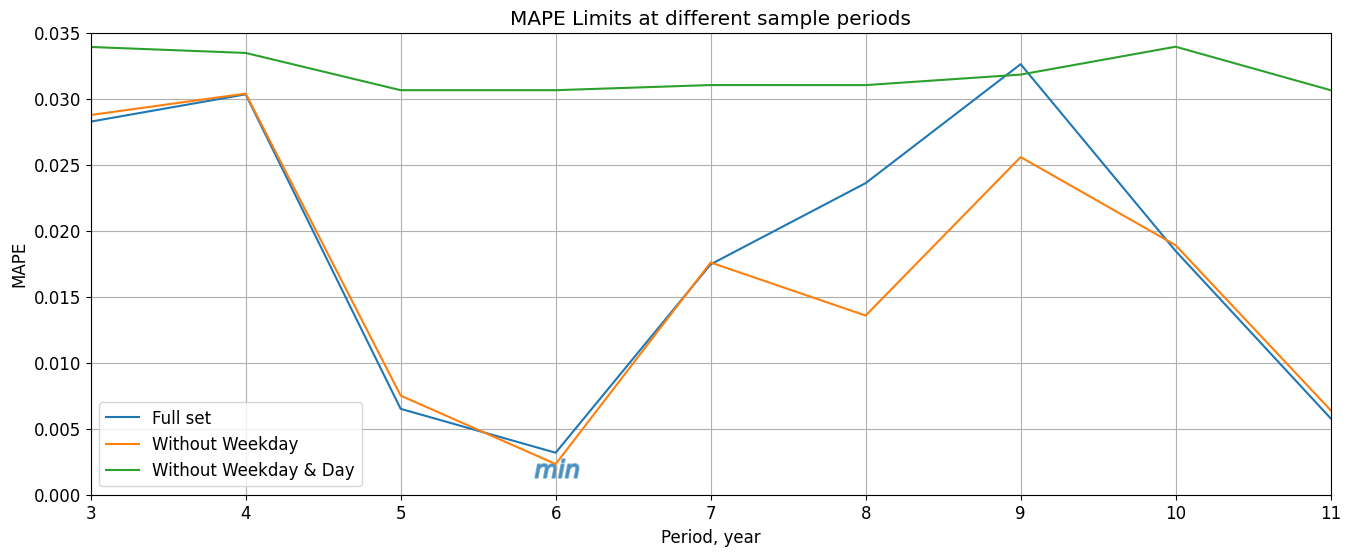

In [37]:
plot_gen = list()
for i in range(len(messages)):
    plot_gen.append(df_general_result[df_general_result['set'] == messages[i]])
    plot_gen[i]=plot_gen[i][['period', 'MAPE']]
    plot_gen[i].set_index('period', inplace= True)
    plot_gen[i] = plot_gen[i].rename(columns={'MAPE': messages[i].rstrip()[:-1]})

pd.concat([plot_gen[i] for i in range(3)], axis=1).plot(figsize=(16,6), 
                                                        title='MAPE Limits at different sample periods',
                                                        xlim=(3, 11), ylim=(0, 0.035),
                                                        xlabel='Period, year',
                                                        ylabel='MAPE',
                                                        legend=True,
                                                        grid=True)

plt.scatter(df_general_result.period[df_general_result.MAPE.idxmin()], 
            df_general_result.MAPE.min()-0.0003,
            linewidth=1.5,
            marker='$min$',
            alpha=0.6,
            s=1000)

**Выводы**: 
1. Фильтрация малозначимых исходных данных в *большинстве* случаев **снижает** точность прогнозной модели. 
2. Ограничение объема тестовой выборки приводит к **снижению** погрешности на 0.18–1.28% (!). Лучший результат был получен для тестовой выборки объемом в **6 лет**.
3. Полученный результат близок к тому, что описан в [статье](https://www.mdpi.com/2411-5134/8/5/114)

*Оценка прогнозирования за 2023 год при оптимальных гиперпараметрах с разбивкой по месяцам*

In [47]:
%%time

df_boost_test = df_test.copy()  # формируем тестовый датафрейм
df_boost_train = df[df['Year'] > 2017]  # формируем валидационный датафрейм

# обучаем модель
model = xgb.XGBRegressor(tree_method = 'gpu_hist',  # включаем ранее найденные оптимальные гиперпараметры 
                         n_estimators = 100,
                         max_depth = 10)

model.fit(df_boost_train[dataset[0]], df_boost_train['Volume'])
df_boost_test[predictions[0]] = model.predict(df_boost_test[dataset[0]])
df_boost_test['Error'] = abs((df_boost_test['Volume'] - df_boost_test['Predicted'])*100/df_boost_test['Volume'])

CPU times: total: 1.72 s
Wall time: 1.83 s


In [48]:
month = list(name for name in calendar.month_name)

df_month_result = pd.DataFrame({'Month':[],
                                'MAE [MW]':[],
                                'MAPE':[]})

for i in range(12):
    df_month = df_boost_test[df_boost_test['Month'] == i + 1]
    if df_month.shape[0]:
        df_month_result.loc[i] = (month[i + 1],
                                  f"{MAE(df_month['Predicted'], df_month['Volume']):.2f}", 
                                  f"{MAPE(df_month['Predicted'], df_month['Volume']):.2%}")


#df_month_result.set_index("Month")
df_month_result

,Month,MAE [MW],MAPE
0,January,4.54,0.12%
1,February,5.98,0.16%
2,March,6.30,0.18%
3,April,6.47,0.21%
4,May,6.53,0.22%
5,June,7.55,0.25%
6,July,6.61,0.22%
7,August,6.56,0.21%
8,September,6.72,0.23%
9,October,7.55,0.23%


*Сравнение прогнозных значений с фактическими*

Text(0.5, 1.0, 'The segment of the model testing process (December 2023)')

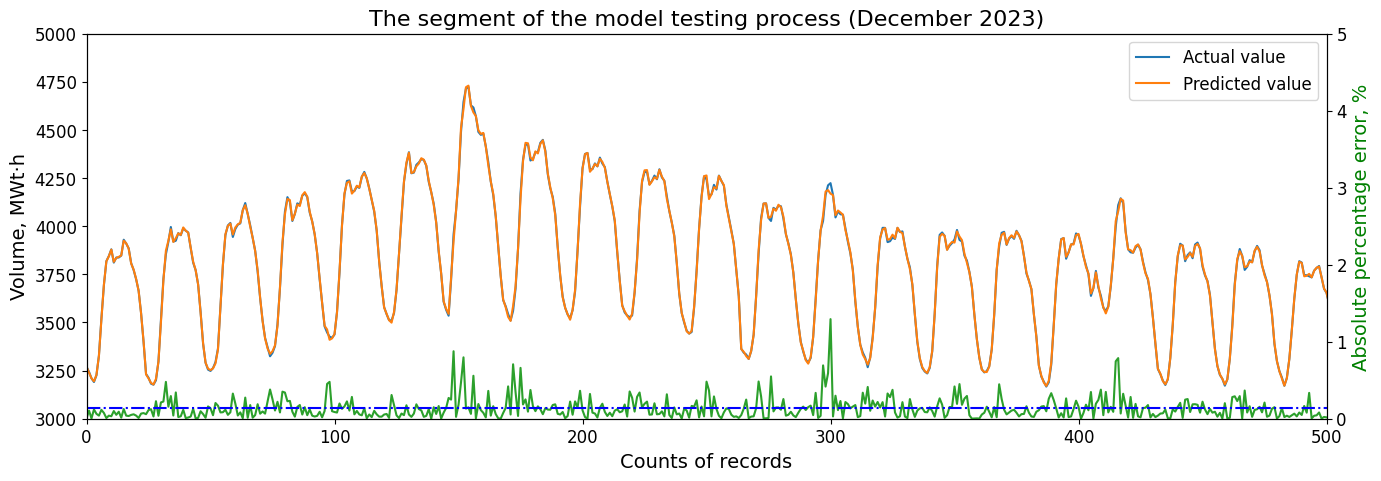

In [52]:
df_sept = df_boost_test[df_boost_test['Month'] == 12]
df_sept.insert(df_sept.shape[1], 'MAPE', MAPE(df_sept['Predicted'], df_sept['Volume'])*100)
df_sept.reset_index(drop=True, inplace=True)

fig, df_volume = plt.subplots(figsize=(16,5))
df_error = df_volume.twinx()

df_volume.plot(df_sept['Volume'], label='Actual value')
df_volume.plot(df_sept['Predicted'], label='Predicted value')
df_error.plot(df_sept['Error'], label='Error, %', color='#2ca02c')
df_error.plot(df_sept['MAPE'], '-.b')

plt.rcParams['font.size'] = '12'

df_volume.legend(loc='upper right')
df_volume.set_xlim(0, 500)
df_volume.set_ylim(3000, 5000)
df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
df_volume.set_xlabel('Counts of records', fontsize = 14)

df_error.set_ylim(0, 5)
df_error.set_ylabel('Absolute percentage error, %', fontsize = 14, color='g')

plt.title('The segment of the model testing process (December 2023)', fontsize = 16)

**Вывод**: полученный результат близок к тому, что описан в [статье](https://www.mdpi.com/2411-5134/8/5/114)